In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath(".")))

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader

from data.segmentation import SegmentDataset
from model.segmentation.fcn import FCN32
from model.segmentation.unet import UNetVGG16

%load_ext autoreload
%autoreload 2

In [3]:
def color_mask(mask, dataset):
    cmask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.int)
    for i, color in enumerate(dataset.COLORS):
        x_indices, y_indices = np.where(mask == i)
        cmask[x_indices, y_indices] = np.array(color, dtype=np.int)
    return cmask

In [4]:
def mean_iou_score(pred_masks, true_masks):
    """Compute mean IoU score over 6 classes"""
    mean_iou = 0
    for i in range(6):
        tp_fp = np.sum(pred_masks == i)
        tp_fn = np.sum(true_masks == i)
        tp = np.sum((pred_masks == i) * (true_masks == i))
        iou = tp / (tp_fp + tp_fn - tp)
        mean_iou += iou / 6
    return mean_iou

# Load Validation data

In [5]:
TRAIN_DIR = "../hw2_data/p2_data/train/"
VALID_DIR = "../hw2_data/p2_data/validation/"

DEVICE = "cuda:1"
BASE_CHECKPOINT_FILE = "../run/fcn32_checkpoint/best.pth"
BEST_CHECKPOINT_FILE = "../run/unet_checkpoint/best.pth"

In [6]:
# Validation preparation dataset
transform = T.Compose([T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])])
dataset = SegmentDataset(VALID_DIR, transform=transform)

# Load pretrained model

In [7]:
base_model = FCN32(n_classes=7)
best_model = UNetVGG16(n_classes=7)

# Base model
checkpoint = torch.load(BASE_CHECKPOINT_FILE)
base_model.load_state_dict(checkpoint['model'])
base_model = base_model.to(DEVICE)
base_model = base_model.eval()

# Best model
checkpoint = torch.load(BEST_CHECKPOINT_FILE)
best_model.load_state_dict(checkpoint['model'])
best_model = best_model.to(DEVICE)
best_model = best_model.eval()

# Base model inference

In [8]:
SAMPLE_INDICES = [ 10, 97, 107 ]

raw_imgs = []
true_masks = []
pred_masks = []
for ind in SAMPLE_INDICES:
    # Get raw img
    fname = dataset.pairs[ind][0]
    raw_img = np.array(Image.open(fname))
    raw_imgs.append(raw_img)
    
    # Predict mask
    img, mask = dataset[ind]
    img = img.to(DEVICE)
    mask = mask.to(DEVICE)
    output = base_model(img.unsqueeze(0))[0]

    # Move to cpu
    pred = output.detach().cpu().numpy()
    pred_mask = np.argmax(pred, axis=0)
    true_mask = mask.detach().cpu().numpy()
    
    # Save result
    pred_masks.append(pred_mask)
    true_masks.append(true_mask)

# Base mask

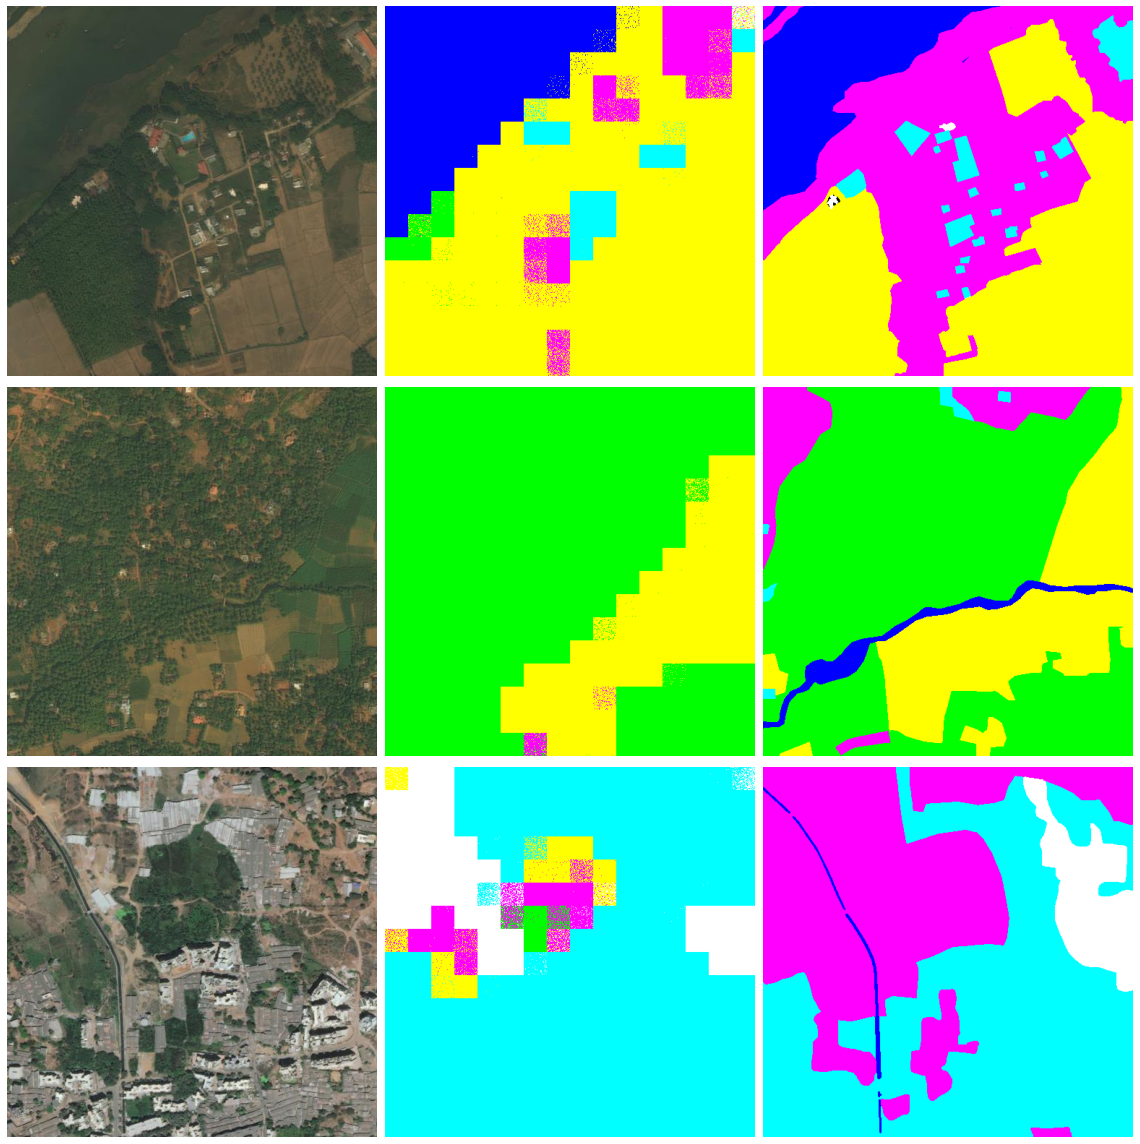

In [9]:
fig, axes = plt.subplots(nrows=len(raw_imgs), ncols=3, figsize=(16, 16))

for i, (img, pmask, gmask) in enumerate(list(zip(raw_imgs, pred_masks, true_masks))):
    # display
    axes[i][0].imshow(img)
    axes[i][0].set_axis_off()
    axes[i][1].imshow(color_mask(pmask, dataset))
    axes[i][1].set_axis_off()
    axes[i][2].imshow(color_mask(gmask, dataset))
    axes[i][2].set_axis_off()
    
plt.tight_layout()

# Best model inference

In [10]:
SAMPLE_INDICES = [ 10, 97, 107 ]

raw_imgs = []
true_masks = []
pred_masks = []
for ind in SAMPLE_INDICES:
    # Get raw img
    fname = dataset.pairs[ind][0]
    raw_img = np.array(Image.open(fname))
    raw_imgs.append(raw_img)
    
    # Predict mask
    img, mask = dataset[ind]
    img = img.to(DEVICE)
    mask = mask.to(DEVICE)
    output = best_model(img.unsqueeze(0))[0]

    # Move to cpu
    pred = output.detach().cpu().numpy()
    pred_mask = np.argmax(pred, axis=0)
    true_mask = mask.detach().cpu().numpy()
    
    # Save result
    pred_masks.append(pred_mask)
    true_masks.append(true_mask)

# Best mask

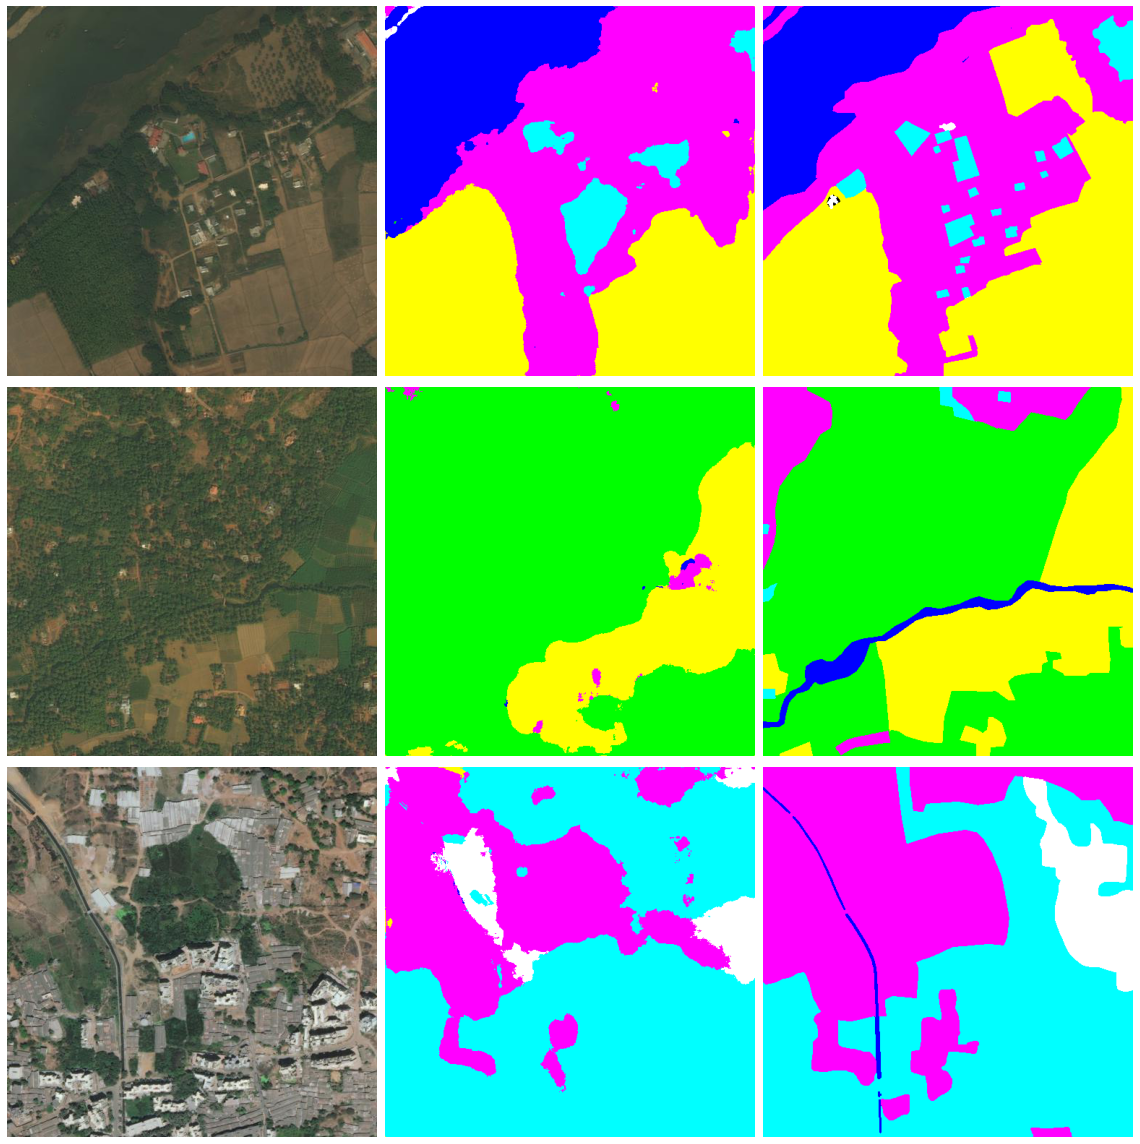

In [11]:
fig, axes = plt.subplots(nrows=len(raw_imgs), ncols=3, figsize=(16, 16))

for i, (img, pmask, gmask) in enumerate(list(zip(raw_imgs, pred_masks, true_masks))):
    # display
    axes[i][0].imshow(img)
    axes[i][0].set_axis_off()
    axes[i][1].imshow(color_mask(pmask, dataset))
    axes[i][1].set_axis_off()
    axes[i][2].imshow(color_mask(gmask, dataset))
    axes[i][2].set_axis_off()
    
plt.tight_layout()